In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scalable_gps import data
from scalable_gps.kernels import Matern32Kernel
from scalable_gps.models import ExactGPModel, SGDGPModel
from scalable_gps.utils import revert_z_score
from scalable_gps.eval_utils import RMSE

data_train, data_test = data.get_dataset('pol', split=0, normalise=True)

/homes/jal232/miniconda3/envs/jax/lib/python3.8/site-packages/jax/_src/api_util.py:183: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


pol dataset, N=15000, d=26


In [2]:
def softminus(x):
    return math.log(math.exp(x) - 1)

import math
signal_scale = math.sqrt(0.07279852032661438)
length_scale = 1.88330865
length_scale_ard = jnp.array([0.40078604, 0.47861066, 0.99160534, 1.8033762,  1.3364722,  3.6816106,
   3.6552188,  6.462375,   6.962077,   4.8550777,  2.6934228,  2.2448704,
   5.32376,    5.58768,    6.0296025,  3.2405155,  6.1585517,  6.8495193,
   5.000094,   5.8355484,  5.228479,   6.537194,   6.9643164,  5.146025,
   5.5808063,  5.1676707])
noise_scale = math.sqrt(0.0007456933963112533)

signal_scale_init = math.sqrt(math.log(2.))
length_scale_init = jnp.arange(1., 27.)
noise_scale_init = math.sqrt(math.log(2.))

kernel_config = {
    'signal_scale': signal_scale,
    'length_scale': length_scale
}

kernel_config_ard = {
    'signal_scale': signal_scale,
    'length_scale': length_scale_ard
}

kernel_config_init = {
    'signal_scale': signal_scale_init,
    'length_scale': length_scale_init
}

kernel = Matern32Kernel(kernel_config=kernel_config)

In [3]:
exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)

exact_gp.compute_representer_weights(data_train)
exact_pred_mean = exact_gp.predictive_mean(data_train, data_test)
exact_pred_var = exact_gp.predictive_variance(data_train, data_test) + noise_scale ** 2
exact_pred_std = jnp.sqrt(exact_pred_var)


In [4]:
print(data_test.y.shape, exact_pred_mean.shape, exact_pred_std.shape)
# loc = revert_z_score(exact_pred_mean, mu=data_train.mu_y, sigma=data_train.sigma_y)
# scale = revert_z_score(exact_pred_std, mu=0., sigma=data_train.sigma_y)
# y = revert_z_score(data_test.y, mu=data_train.mu_y, sigma=data_train.sigma_y)
loc = exact_pred_mean
scale = exact_pred_std
y = data_test.y

test_rmse = RMSE(y, loc)
print(test_rmse)
test_llh = jax.scipy.stats.norm.logpdf(y, loc, scale).mean()
print(test_llh)

(1500,) (1500,) (1500,)
0.15296917
0.26724586


In [20]:
import ml_collections
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.learning_rate = 1e-1
config.train_config.momentum = 0.9
config.train_config.polyak = 1e-3
config.train_config.iterations = int(2e5)
config.train_config.batch_size = 1000
config.train_config.eval_every = 100
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

optim_key = jax.random.PRNGKey(123)

sgd_gp = SGDGPModel(noise_scale=noise_scale, kernel=kernel)
alpha, info = sgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=data_train,
    test_ds=data_test,
    config=config.train_config,
    metrics_list=['loss'],
    exact_metrics=None
)

sgd_pred_mean = sgd_gp.predictive_mean(data_train, data_test)

100%|██████████| 200000/200000 [20:56<00:00, 159.14it/s]


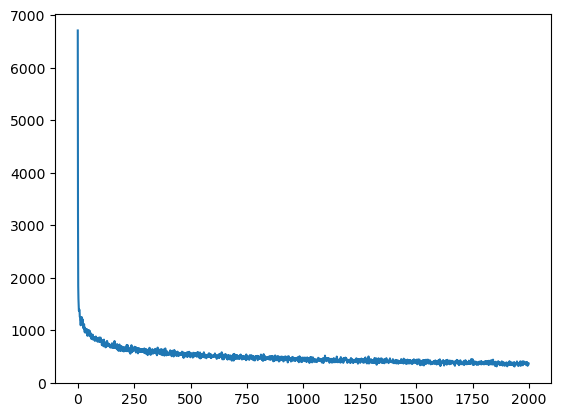

In [21]:
info_dict = {k: [dic[k].item() for dic in info] for k in info[0]}
loss = info_dict['/loss']
plt.plot(loss)

In [11]:
sgd_pred_std = jnp.array(0.)

In [22]:
print(data_test.y.shape, sgd_pred_mean.shape, sgd_pred_std.shape)
# loc = revert_z_score(sgd_pred_mean, mu=data_train.mu_y, sigma=data_train.sigma_y)
# scale = revert_z_score(sgd_pred_std, mu=0., sigma=data_train.sigma_y)
# y = revert_z_score(data_test.y, mu=data_train.mu_y, sigma=data_train.sigma_y)
loc = sgd_pred_mean
scale = sgd_pred_std
y = data_test.y

test_rmse = RMSE(y, loc)
print(test_rmse)
# test_llh = jax.scipy.stats.norm.logpdf(y, loc, scale).mean()
# print(test_llh)

(1500,) (1500,) ()
0.24783106
